In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\2184016862.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class Animal:
    def __init__(self, name, health, speed):
        self.name = name
        self.health = health
        self.speed = speed
        self.alive = True

    def is_alive(self):
        return self.health > 0

    def reproduce(self, offspring_list):
        if self.health > 6:              # Changing minimum health can deteremine a bounce back
            offspring = self.__class__(f"Offspring of {self.name}", 10, self.speed)
            offspring_list.append(offspring)

In [3]:
############### ~~~ CONSTANTS ~~~ ###############

MIN_RABBIT_SPEED = 3
CARRYING_CAPACITY = 100

ESCAPE_CHANCE_FACTOR = 0.6 # 0.75 seems to work the best

In [4]:
class Prey(Animal):
    def __init__(self, name, health, speed):
        super().__init__(name, health, speed)
        self.camouflage = 10 - self.speed
        self.sense = random.randint(1, 10)

    def adapt(self):
        if not self.is_alive():
            return
        
        # Randomly decide to increase or decrease speed
        speed_change = random.choice([-1, 0, 1])
        if self.speed + speed_change > 10:
            speed_change = 0
        elif self.speed + speed_change < 0:
            speed_change = 0
        
        new_speed = self.speed + speed_change
        new_camouflage = 10 - new_speed
        
        if 0 <= new_speed <= 10 and 0 <= new_camouflage <= 10:
            self.speed = new_speed
            self.camouflage = new_camouflage

    def find_food(self):
        if random.random() < self.sense / 10:
            return True
        else:
            self.health = 0
            self.alive = False
            return False

    def flee(self, predator_speed):
        if predator_speed == 0:
            predator_speed = 1

        relative_speed_factor = (self.speed / max(predator_speed, 1))
        
        escape_chance = max(0.1, ESCAPE_CHANCE_FACTOR * relative_speed_factor)
        
        if random.random() < escape_chance:
            return True
        return False

In [5]:
class Predator(Animal):
    def __init__(self, name, health, speed):
        super().__init__(name, health, speed)
        self.perception = 10 - self.speed
        self.has_eaten = False

    def hunt(self, prey):
        if self.is_alive() and prey.is_alive():

            effective_perception = (self.perception + 2) - math.sqrt(max(prey.camouflage, 0))   # Making wolves the more effective hunters compared to foxes

            detection_chance = max(effective_perception, 0) / 10

            if random.random() < detection_chance:
                # Pass the predator's speed to the prey's flee method
                if prey.flee(self.speed):
                    return False
                prey.health -= random.randint(5, 15)
                self.health += 3
                self.has_eaten = True
                if prey.health <= 0:
                    prey.alive = False
                return True
            return False

    def check_hunger(self):
        if not self.has_eaten:
            self.health -= 5
            if self.health <= 0:
                self.alive = False
        self.has_eaten = False

    def adapt(self):
        if not self.is_alive():
            return

        if random.choice([True, False]):
            if self.speed < 9:
                self.speed += 1
                self.perception = max(self.perception - 1, 0)
        else:
            if self.perception < 9:
                self.perception += 1
                self.speed = max(self.speed - 1, 0)

In [6]:
def run_simulation(days, num_rabbits, num_wolves):
    rabbits = [Prey(f"Rabbit {i+1}", 10, random.randint(3, 10)) for i in range(num_rabbits)]
    wolves = [Predator(f"Wolf {i+1}", 15, random.randint(5, 10)) for i in range(num_wolves)]
    records = pd.DataFrame(columns=['Day', 'Animal Type', 'Name', 'Health', 'Speed', 'Sense/Camouflage', 'Alive'])

    for day in range(1, days + 1):
        daily_records = []

        rabbits = [rabbit for rabbit in rabbits if rabbit.is_alive()]
        wolves = [wolf for wolf in wolves if wolf.is_alive()]

        new_rabbits = []
        new_wolves = []

        for rabbit in rabbits:
            if rabbit.find_food():
                rabbit.adapt()
                rabbit.reproduce(new_rabbits)

        for wolf in wolves:
            available_rabbits = [rabbit for rabbit in rabbits if rabbit.is_alive()]
            for rabbit in available_rabbits:
                wolf.hunt(rabbit)
            wolf.check_hunger()
            wolf.adapt()
            wolf.reproduce(new_wolves)

        rabbits.extend(new_rabbits)
        wolves.extend(new_wolves)

        # Carrying capacity check, kills off a varied excess if too high (grass too low, cannibalism, etc.)
        if len(rabbits) > CARRYING_CAPACITY:
            excess = len(rabbits) - CARRYING_CAPACITY
            death_toll = int(excess * random.uniform(0.5, 1.5))
            random.shuffle(rabbits)
            rabbits = rabbits[death_toll:]

        daily_records = [{
            'Day': day,
            'Animal Type': 'Rabbit',
            'Name': rabbit.name,
            'Health': rabbit.health,
            'Speed': rabbit.speed,
            'Sense/Camouflage': rabbit.camouflage,
            'Alive': rabbit.is_alive()
        } for rabbit in rabbits] + [{
            'Day': day,
            'Animal Type': 'Wolf',
            'Name': wolf.name,
            'Health': wolf.health,
            'Speed': wolf.speed,
            'Sense/Camouflage': wolf.perception,
            'Alive': wolf.is_alive()
        } for wolf in wolves]

        # Concatenate daily records to the main records DataFrame
        records = pd.concat([records, pd.DataFrame(daily_records)], ignore_index=True)

    return records

In [7]:
def plot_animal_populations(data_frame):
    if 'Alive' in data_frame.columns:
        data_frame = data_frame[data_frame['Alive']]

    rabbit_counts = data_frame[data_frame['Animal Type'] == 'Rabbit'].groupby('Day').size()
    wolf_counts = data_frame[data_frame['Animal Type'] == 'Wolf'].groupby('Day').size()

    # Ensure all days are represented in the series, fill missing days with zero
    max_day = data_frame['Day'].max()
    days = range(1, max_day + 1)
    rabbit_counts = rabbit_counts.reindex(days, fill_value=0)
    wolf_counts = wolf_counts.reindex(days, fill_value=0)

    fig, ax = plt.subplots()

    ax.stackplot(days, rabbit_counts, wolf_counts, labels=['Rabbits', 'Wolves'], colors=['skyblue', 'salmon'])

    ax.set_title('Animal Populations Over Time')
    ax.set_xlabel('Day')
    ax.set_ylabel('Number of Animals')

    ax.legend(loc='upper right')

    plt.show()

In [8]:
def plot_average_trait_per_day(data_frame, animal_type, trait):
    filtered_data = data_frame[(data_frame['Animal Type'] == animal_type) & data_frame['Alive']]
    
    average_trait_per_day = filtered_data.groupby('Day')[trait].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(average_trait_per_day.index, average_trait_per_day.values, marker='o', linestyle='-', color='royalblue')
    plt.title(f'Average {trait.capitalize()} for {animal_type}s Over Time')
    plt.xlabel('Day')
    plt.ylabel(f'Average {trait.capitalize()}')
    plt.grid(True)
    plt.show()

In [9]:
def plot_multiple_traits_per_day(data_frame, animal_type, traits):
    filtered_data = data_frame[(data_frame['Animal Type'] == animal_type) & data_frame['Alive']]
    
    plt.figure(figsize=(12, 8))
    colors = ['red', 'blue', 'orange', 'green', 'purple']
    
    for i, trait in enumerate(traits):
        average_trait_per_day = filtered_data.groupby('Day')[trait].mean()
        
        plt.plot(average_trait_per_day.index, average_trait_per_day.values, marker='o', linestyle='-', color=colors[i % len(colors)], label=f'Average {trait}')
    
    plt.title(f'Average Traits for {animal_type}s Over Time')
    plt.xlabel('Day')
    plt.ylabel('Average Value')
    plt.legend(title='Traits')
    plt.grid(True)

    plt.show()

In [10]:
def plot_traits_across_animal_types(data_frame, animal_types, traits):
    plt.figure(figsize=(12, 8))
    
    color_palettes = {
        'Rabbit': ['blue', 'green', 'lightblue', 'cyan'],
        'Fox': ['purple', 'magenta', 'pink', 'violet'],
        'Wolf': ['red', 'orange', 'yellow', 'darkred']
    }
    markers = ['o', '^', 's', 'P']
    
    for i, animal_type in enumerate(animal_types):
        colors = color_palettes.get(animal_type, ['black'])
        for j, trait in enumerate(traits):
            # Only want alive animals
            filtered_data = data_frame[(data_frame['Animal Type'] == animal_type) & data_frame['Alive']]
            
            average_trait_per_day = filtered_data.groupby('Day')[trait].mean()
            
            plt.plot(average_trait_per_day.index, average_trait_per_day.values,
                     marker=markers[j % len(markers)], linestyle='-', color=colors[j % len(colors)],
                     label=f'{trait} ({animal_type})')
    
    plt.title('Average Traits Across Animal Types Over Time')
    plt.xlabel('Day')
    plt.ylabel('Average Trait Value')
    plt.legend(title='Traits by Animal Type')
    plt.grid(True)
    plt.show()

In [155]:
random.seed(420)
ESCAPE_CHANCE_FACTOR = 0.80

data_frame = run_simulation(50, 40, 5)

Perfect predator prey oscillations?:
random.seed(420), ESCAPE_CHANCE_FACTOR = 0.8, 50 days, 40 rabbits, 5 wolves

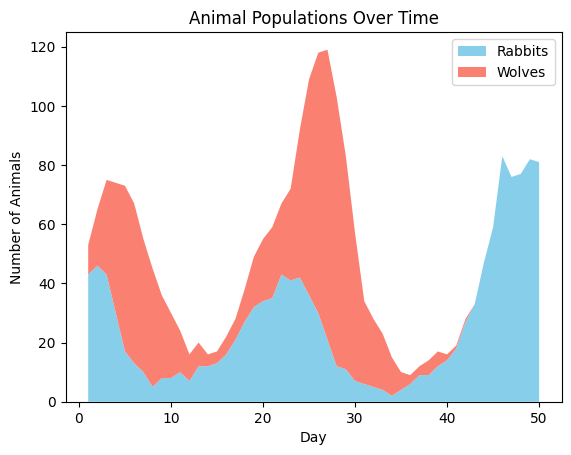

In [156]:
plot_animal_populations(data_frame)

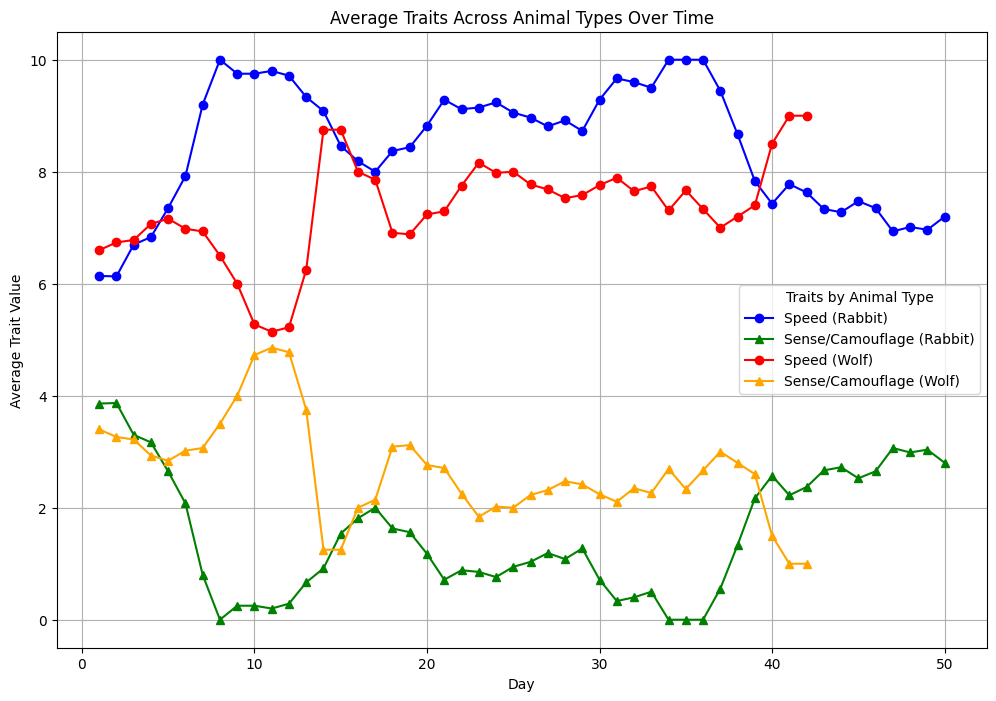

In [157]:
plot_traits_across_animal_types(data_frame, ['Rabbit', 'Wolf'], ['Speed', 'Sense/Camouflage'])

# A Middle Predator

I will now introduce a middle predator: a fox in order to see how dynamics change.

In [14]:
class Fox(Animal):
    def __init__(self, name, health, speed):
        super().__init__(name, health, speed)
        self.perception = (10 - self.speed) / 2  # Distribute the remaining points between perception and camouflage
        self.camouflage = 10 - self.speed - self.perception
        self.has_eaten = False

    def hunt(self, prey):
        if self.is_alive() and prey.is_alive():
            detection_chance = self.perception / 10  # Foxes are less effective hunters than wolves
            if random.random() < detection_chance:
                if prey.flee(self.speed):
                    return False
                prey.health -= random.randint(3, 7)  # Foxes do less damage than wolves
                if prey.health <= 0:
                    prey.alive = False
                    self.health += 3
                self.has_eaten = True
                return True
        return False

    def flee(self, predator_speed):
        escape_chance = (self.speed + self.camouflage) / predator_speed * 1.2  # Foxes are good at escaping so no change from ESCAPE_CHANCE_FACTOR
        if random.random() < escape_chance:
            return True
        return False
    
    def check_hunger(self):
        if not self.has_eaten:
            self.health -= 5
            if self.health <= 0:
                self.alive = False
        self.has_eaten = False

    def adapt(self):
        if not self.is_alive():
            return

        if random.choice([True, False]):
            if self.speed < 9:
                self.speed += 1
                self.perception = max(self.perception - 1, 0)
        else:
            if self.perception < 9:
                self.perception += 1
                self.speed = max(self.speed - 1, 0)

In [15]:
def run_full_simulation(days, num_rabbits, num_foxes, num_wolves):
    rabbits = [Prey(f"Rabbit {i+1}", 10, random.randint(3, 10)) for i in range(num_rabbits)]
    wolves = [Predator(f"Wolf {i+1}", 15, random.randint(5, 10)) for i in range(num_wolves)]
    foxes = [Fox(f"Fox {i+1}", 12, random.randint(4, 8)) for i in range(num_foxes)]
    records = pd.DataFrame(columns=['Day', 'Animal Type', 'Name', 'Health', 'Speed', 'Sense/Camouflage', 'Alive'])

    initial_records = []
    for animal_list, animal_type in zip([rabbits, wolves, foxes], ['Rabbit', 'Wolf', 'Fox']):
        for animal in animal_list:
            initial_records.append({
                'Day': 0,
                'Animal Type': animal_type,
                'Name': animal.name,
                'Health': animal.health,
                'Speed': animal.speed,
                'Sense/Camouflage': getattr(animal, 'camouflage', getattr(animal, 'perception', 0)),
                'Alive': animal.is_alive()
            })
    
    # Append initial records to the main DataFrame
    records = pd.concat([records, pd.DataFrame(initial_records)], ignore_index=True)


    for day in range(1, days + 1):
        daily_records = []

        rabbits = [rabbit for rabbit in rabbits if rabbit.is_alive()]
        wolves = [wolf for wolf in wolves if wolf.is_alive()]
        foxes = [fox for fox in foxes if fox.is_alive()]

        new_rabbits = []
        new_wolves = []
        new_foxes = []

        for rabbit in rabbits:
            if rabbit.find_food():
                rabbit.adapt()
                rabbit.reproduce(new_rabbits)

        for fox in foxes:
            available_rabbits = [rabbit for rabbit in rabbits if rabbit.is_alive()]
            for rabbit in available_rabbits:
                if fox.hunt(rabbit):
                    fox.has_eaten = True
            fox.check_hunger()
            fox.adapt()
            fox.reproduce(new_foxes)

        for wolf in wolves:
            potential_prey = [animal for animal in foxes + rabbits if animal.is_alive()]
            for prey in potential_prey:
                if isinstance(prey, Fox) and prey.flee(wolf.speed):
                    continue
                wolf.hunt(prey)
            wolf.check_hunger()
            wolf.adapt()
            wolf.reproduce(new_wolves)

        rabbits.extend(new_rabbits)
        wolves.extend(new_wolves)
        foxes.extend(new_foxes)

        if len(rabbits) > CARRYING_CAPACITY:
            excess = len(rabbits) - CARRYING_CAPACITY
            death_toll = int(excess * random.uniform(0.5, 1.5))
            random.shuffle(rabbits)
            rabbits = rabbits[death_toll:]

        daily_records.extend([{
            'Day': day,
            'Animal Type': 'Rabbit',
            'Name': rabbit.name,
            'Health': rabbit.health,
            'Speed': rabbit.speed,
            'Camouflage': rabbit.camouflage,
            'Perception': None,  # Rabbits do not have Perception
            'Alive': rabbit.is_alive()
        } for rabbit in rabbits])

        daily_records.extend([{
            'Day': day,
            'Animal Type': 'Wolf',
            'Name': wolf.name,
            'Health': wolf.health,
            'Speed': wolf.speed,
            'Camouflage': None,  # Wolves do not have Camouflage
            'Perception': wolf.perception,
            'Alive': wolf.is_alive()
        } for wolf in wolves])

        daily_records.extend([{
            'Day': day,
            'Animal Type': 'Fox',
            'Name': fox.name,
            'Health': fox.health,
            'Speed': fox.speed,
            'Camouflage': fox.camouflage,
            'Perception': fox.perception,
            'Alive': fox.is_alive()
        } for fox in foxes])

        # Concatenate daily records to the main records DataFrame
        if daily_records:
            records = pd.concat([records, pd.DataFrame(daily_records)], ignore_index=True)

    return records

In [16]:
def plot_all_animal_populations(data_frame):
    if 'Alive' in data_frame.columns:
        data_frame = data_frame[data_frame['Alive']]

    rabbit_counts = data_frame[data_frame['Animal Type'] == 'Rabbit'].groupby('Day').size()
    fox_counts = data_frame[data_frame['Animal Type'] == 'Fox'].groupby('Day').size()
    wolf_counts = data_frame[data_frame['Animal Type'] == 'Wolf'].groupby('Day').size()

    # Ensure all days are represented in the series, fill missing days with zero
    max_day = data_frame['Day'].max()
    days = range(0, max_day + 1)
    rabbit_counts = rabbit_counts.reindex(days, fill_value=0)
    fox_counts = fox_counts.reindex(days, fill_value=0)
    wolf_counts = wolf_counts.reindex(days, fill_value=0)

    fig, ax = plt.subplots()

    ax.stackplot(days, rabbit_counts, fox_counts, wolf_counts, labels=['Rabbits', 'Foxes', 'Wolves'], colors=['skyblue', 'lightgreen', 'salmon'])

    ax.set_title('Animal Populations Over Time')
    ax.set_xlabel('Day')
    ax.set_ylabel('Number of Animals')

    ax.legend(loc='upper right')

    plt.show()

In [134]:
random.seed(990)

R0 = 40
F0 = 12
W0 = 6
d = 30

ESCAPE_CHANCE_FACTOR = 0.6

data_frame_2 = run_full_simulation(d, R0, F0, W0)

C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\2431416203.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  records = pd.concat([records, pd.DataFrame(initial_records)], ignore_index=True)
C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\2431416203.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  records = pd.concat([records, pd.DataFrame(daily_records)], ignore_index=True)
C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\2431416203.py:104: FutureWarning: The behavior of DataFram

random.seed(990), R0 = 40, F0 = 12, W0 = 6, d = 30 is a good fix.

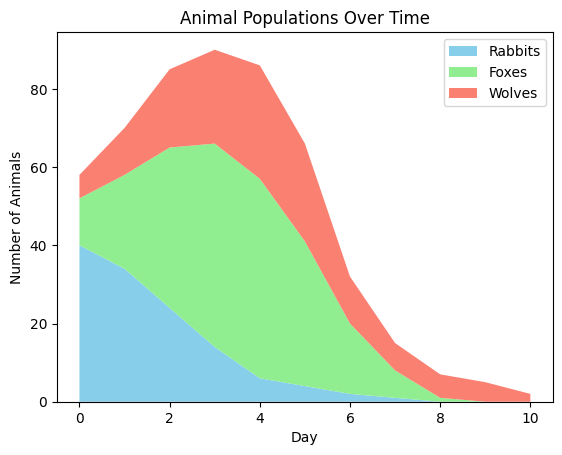

In [135]:
plot_all_animal_populations(data_frame_2)

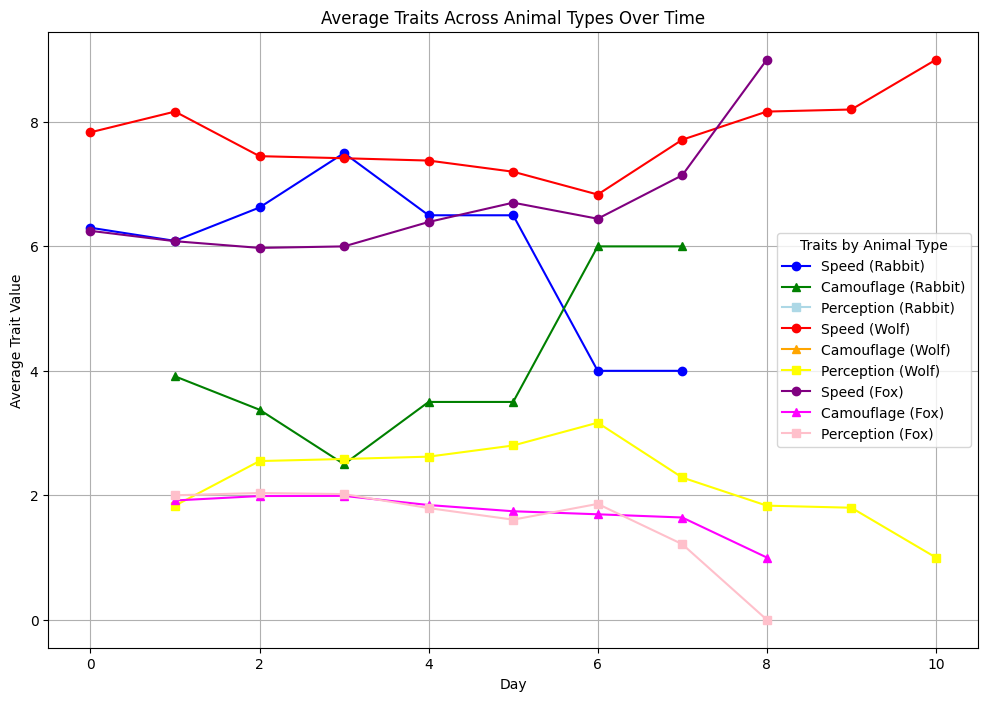

In [136]:
plot_traits_across_animal_types(data_frame_2, ['Rabbit', 'Wolf', 'Fox'], ['Speed', 'Camouflage', 'Perception'])

Running something like this:
random.seed(1234)

data_frame_2 = run_full_simulation(20, 50, 5, 5)

We generally see that over time the predators over hunt and then the middle predator is taken out first by the apex predator and then eventually they too die out as the rabbit population dwindles then bounces back

With foxes performing worse (gaining less health, better at escaping, do less damage)

# As differential equations:

dR/dt = alpha R - mu R F - nu R W
dF/dt = beta R F - epsilon F - theta F W
dW/dt = gamma R F + gamma F W

In [137]:
from scipy.integrate import odeint

In [138]:
def equations(y, t, params):
    R, F, W = y
    alpha, beta, gamma, mu, nu, epsilon, zeta, theta= params

    dRdt = alpha * R - mu * R * F - nu * R * W
    dFdt = beta * R * F - epsilon * F - theta * F * W
    dWdt = gamma * (R * F + F * W) - zeta * W

    return [dRdt, dFdt, dWdt]

In [139]:
# Parameters:

def cost_function(params, observed_data, time_points):
    alpha, beta, gamma, mu, nu, epsilon, zeta, theta = params

    def derivatives(y, t):
        R, F, W = y
        dRdt = alpha * R - mu * R * F - nu * R * W
        dFdt = beta * R * F - epsilon * F - theta * F * W
        dWdt = gamma * (R * F + F * W) - zeta * W
        return [dRdt, dFdt, dWdt]
    
    y0 = observed_data[0]

    solution = odeint(derivatives, y0, time_points)

    cost = np.sum((solution - observed_data)**2)

    return cost

In [140]:
def track(data_frame):
    if 'Alive' in data_frame.columns:
        data_frame = data_frame[data_frame['Alive']]
    
    # Group by day and count occurrences for each animal type
    rabbit_counts = data_frame[data_frame['Animal Type'] == 'Rabbit'].groupby('Day').size()
    fox_counts = data_frame[data_frame['Animal Type'] == 'Fox'].groupby('Day').size()
    wolf_counts = data_frame[data_frame['Animal Type'] == 'Wolf'].groupby('Day').size()

    max_day = data_frame['Day'].max()
    days = range(0, max_day + 1)
    
    # Reindex to ensure all days are represented, filling missing days with zero
    rabbit_counts = rabbit_counts.reindex(days, fill_value=0)
    fox_counts = fox_counts.reindex(days, fill_value=0)
    wolf_counts = wolf_counts.reindex(days, fill_value=0)

    combined_counts = pd.DataFrame({
        'Day': days,
        'Rabbits': rabbit_counts.values,
        'Foxes': fox_counts.values,
        'Wolves': wolf_counts.values
    })

    return combined_counts


In [141]:
data = track(data_frame_2)


In [142]:
data = track(data_frame_2)

observed_data = np.array(data[['Rabbits', 'Foxes', 'Wolves']], dtype=np.float64)
time_points = np.array(data['Day'], dtype = np.float64)

if np.isnan(observed_data).any() or np.isinf(observed_data).any():
    print('Data contains NaN or Inf values')

In [143]:
from scipy.optimize import minimize, differential_evolution, Bounds

bounds = Bounds([-2, -2, -2, -2, -2, -2, -2, -2], [1, 1, 1, 1, 1, 1, 1, 1])

initial_params = [0.5, 0.02, 0.02, 0.01, 0.01, 0.1, 0.1, 0.05]

result = minimize(cost_function, initial_params, args=(observed_data, time_points))#    , bounds = bounds)

# result2 = differential_evolution(cost_function, bounds, args=(observed_data, time_points))

optimized = result.x

print("Optimized Parameters:", optimized)

# alpha, beta, gamma, mu, nu, epsilon, zeta, theta
print(f'Final Equations:\n')
print(f'dR/dt = {optimized[0]} * R - {optimized[3]} * R * F - {optimized[4]} * R * W')
print(f'dF/dt = {optimized[1]} * R * F - {optimized[5]} * F - {optimized[7]} * F * W')
print(f'dWdt = {optimized[2]} * (R * W + F * W) - {optimized[6]} * W')

C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\3934493238.py:15: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(derivatives, y0, time_points)
C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\3934493238.py:15: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(derivatives, y0, time_points)
C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\3934493238.py:15: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(derivatives, y0, time_points)
C:\Users\Brodie\AppData\Local\Temp\ipykernel_17224\3934493238.py:15: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(derivatives, y0, time_points)
C:\U

Optimized Parameters: [ 0.07108903  0.0483917   0.01414297 -0.07084983  0.1884957   1.4024797
  0.85205701 -0.03690753]
Final Equations:

dR/dt = 0.07108903429598001 * R - -0.07084983039962797 * R * F - 0.1884956966720044 * R * W
dF/dt = 0.04839169569580226 * R * F - 1.4024797043219113 * F - -0.03690752703382583 * F * W
dWdt = 0.01414297129572857 * (R * W + F * W) - 0.8520570087653171 * W


In [144]:
y0 = [R0, F0, W0]

t = np.linspace(0, d, d)

results = odeint(equations, y0, t, args=(optimized,))

rabbits, foxes, wolves = results.T

In [145]:
def run_equations(df, R0 = 50, F0 = 10, W0 = 5, d = 50):
    ''' For simplified running of the equations '''
    
    data = track(df)

    observed_data = np.array(data[['Rabbits', 'Foxes', 'Wolves']], dtype=np.float64)
    time_points = np.array(data['Day'], dtype = np.float64)

    if np.isnan(observed_data).any() or np.isinf(observed_data).any():
        print('Data contains NaN or Inf values')

    initial_params = [0.5, 0.02, 0.02, 0.01, 0.01, 0.1, 0.1, 0.05]

    result = minimize(cost_function, initial_params, args=(observed_data, time_points))

    optimized = result.x


    y0 = [R0, F0, W0]
    t = np.linspace(0, d, d)

    results = odeint(equations, y0, t, args=(optimized,))
    rabbits, foxes, wolves = results.T

    print("Optimized Parameters:", optimized)

    return [optimized, rabbits, foxes, wolves]

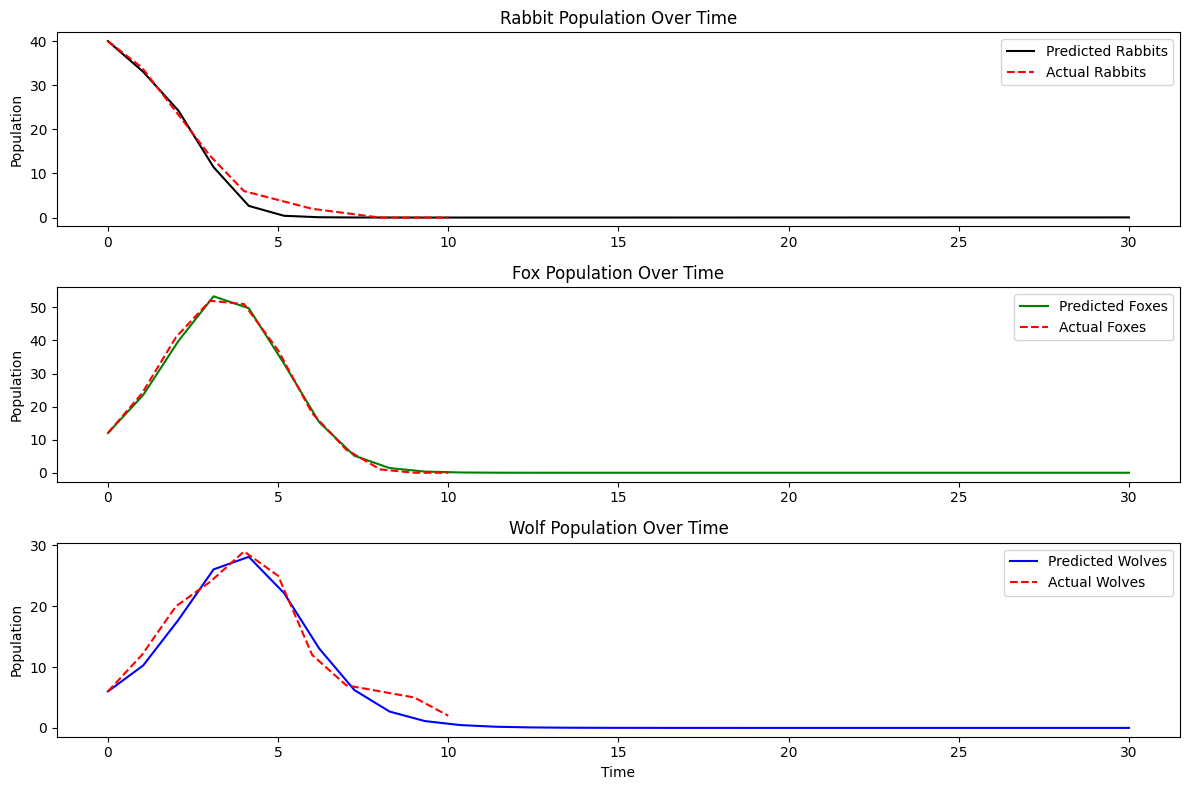

In [146]:
observed_interpolated = data.set_index('Day').interpolate()

actual_rabbits = observed_interpolated['Rabbits']
actual_foxes = observed_interpolated['Foxes']
actual_wolves = observed_interpolated['Wolves']

plt.figure(figsize=(12, 8))

# Rabbits
plt.subplot(3, 1, 1)
plt.plot(t, rabbits, 'k-', label='Predicted Rabbits')
plt.plot(time_points, actual_rabbits, 'r--', label='Actual Rabbits')
plt.title('Rabbit Population Over Time')
plt.ylabel('Population')
plt.legend()

# Foxes
plt.subplot(3, 1, 2)
plt.plot(t, foxes, 'g-', label='Predicted Foxes')
plt.plot(time_points, actual_foxes, 'r--', label='Actual Foxes')
plt.title('Fox Population Over Time')
plt.ylabel('Population')
plt.legend()

# Wolves
plt.subplot(3, 1, 3)
plt.plot(t, wolves, 'b-', label='Predicted Wolves')
plt.plot(time_points, actual_wolves, 'r--', label='Actual Wolves')
plt.title('Wolf Population Over Time')
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()